In [1]:
import os
import numpy as np
import pandas as pd
import opendatasets as od
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

## Pull Data From Kaggle

In [2]:
dataset = "https://www.kaggle.com/datasets/dissfya/atp-tennis-2000-2023daily-pull"
od.download(dataset)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:Your Kaggle Key:Dataset URL: https://www.kaggle.com/datasets/dissfya/atp-tennis-2000-2023daily-pull


100%|██████████| 1.39M/1.39M [00:00<00:00, 2.94MB/s]

In [3]:
PULL_DIR = "atp-tennis-2000-2023daily-pull"

if os.path.exists(PULL_DIR) and os.path.isdir(PULL_DIR):
    
    # Get CSV files in the directory
    for file in os.listdir(PULL_DIR):
        if file.endswith(".csv"):
            csv_file = file

    # Open CSV file using pandas
    csv_path = os.path.join(PULL_DIR, csv_file)
    raw_df = pd.read_csv(csv_path)
else:
    print(f"Directory {PULL_DIR} does not exist.")

## Drop Column & Rows
drop useless column and rows with invalid values

In [4]:
raw_df = raw_df.drop("Tournament", axis=1)
raw_df = raw_df.drop("Date", axis=1)
raw_df = raw_df.drop("Round", axis=1)
raw_df = raw_df.drop("Best of", axis=1)
raw_df = raw_df.drop("Score", axis=1)


In [5]:
raw_df = raw_df[(raw_df["Pts_1"] != -1) & (raw_df["Pts_2"] != -1) & (raw_df["Odd_1"] != -1) & (raw_df["Odd_2"] != -1)]

In [6]:
raw_df.head()

,Series,Court,Surface,Player_1,Player_2,Winner,Rank_1,Rank_2,Pts_1,Pts_2,Odd_1,Odd_2
15652,International,Outdoor,Clay,Robredo T.,Tabara M.,Robredo T.,20,112,1425,381,1.10,6.00
15653,International,Outdoor,Clay,Ryderstedt M.,Vinciguerra A.,Vinciguerra A.,132,917,326,9,1.66,2.10
15654,International,Outdoor,Clay,Youzhny M.,Haehnel J.,Youzhny M.,27,109,1200,391,1.19,4.00
15655,International,Outdoor,Clay,Dlouhy L.,Ferrero J.C.,Ferrero J.C.,136,31,315,1150,7.00,1.07
15656,International,Outdoor,Clay,Berdych T.,Kim K.,Berdych T.,42,71,811,541,1.19,4.00


## EDA

In [7]:
court_count = raw_df['Court'].nunique()
series_count = raw_df['Series'].nunique()
surface_count = raw_df['Surface'].nunique()

players_combined = pd.concat([raw_df['Player_1'], raw_df['Player_2']])
total_players_count = players_combined.nunique()

missing_data = raw_df.isnull().any().any()


print('Shape of raw data: ', raw_df.shape)
print(f'Numbers of court: {court_count}')
print(f'Numbers of series:{series_count}')
print(f'Numbers of surface:{surface_count}')
print(f'Numbers of players:{total_players_count}')
print(f'With missing data: {missing_data}')

Shape of raw data:  (46831, 12)
Numbers of court: 2
Numbers of series:8
Numbers of surface:4
Numbers of players:1336
With missing data: False


## Create Label

In [8]:
raw_df["Label"] = (raw_df["Winner"] == raw_df["Player_1"]).astype("int")

## Create Predictors

In [9]:
raw_df["Player_1"] = raw_df["Player_1"].astype("category").cat.codes
raw_df["Player_2"] = raw_df["Player_2"].astype("category").cat.codes
raw_df["Series"] = raw_df["Series"].astype("category").cat.codes
raw_df["Court"] = raw_df["Court"].astype("category").cat.codes
raw_df["Surface"] = raw_df["Surface"].astype("category").cat.codes

# One-Hot Encoding [Series, Court, Surface]
# raw_encode_df = raw_df[['Series', 'Court', 'Surface']]
# raw_encode_df = pd.get_dummies(raw_encode_df, columns=['Series', 'Court', 'Surface'])

features = ['Series', 'Court', 'Surface', 'Player_1', 'Player_2', 'Rank_1', 'Rank_2', 'Pts_1', 'Pts_2', 'Odd_1', 'Odd_2']
X = raw_df[features]
y = raw_df['Label']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Train

In [11]:
# initialize random forest
rf_classifier = RandomForestClassifier(n_estimators=1500, random_state=100, max_depth=6)

# train model
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(max_depth=6, n_estimators=1500, random_state=100)

## Test & Evaluation

Accuracy:  0.6922173588128536
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.72      0.70      4622
           1       0.71      0.67      0.69      4745

    accuracy                           0.69      9367
   macro avg       0.69      0.69      0.69      9367
weighted avg       0.69      0.69      0.69      9367



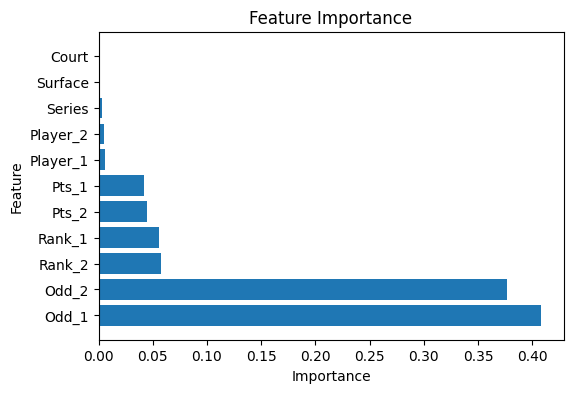

In [12]:
# Test on testing data and generate report
y_pred = rf_classifier.predict(X_test)
report = classification_report(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)
print("Classification Report:")
print(report)

# Get feature importance
feature_importances = rf_classifier.feature_importances_
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Visualise feature importance
plt.figure(figsize=(6, 4))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

In [13]:
X_test.head()

,Series,Court,Surface,Player_1,Player_2,Rank_1,Rank_2,Pts_1,Pts_2,Odd_1,Odd_2
61573,0,1,3,506,428,65,71,802,744,1.50,2.63
45198,0,1,3,1093,998,4,29,5315,1385,1.30,3.40
61290,6,1,3,510,920,26,20,1470,1735,1.80,2.00
47408,1,1,3,552,1042,78,41,652,1115,2.00,1.72
51194,0,1,1,947,1022,314,323,96,91,1.72,2.00
